# Volume 3: GMM
    Benj McMullin
    Math 405
    2/6/2024

In [40]:
import numpy as np
from scipy import stats as st
from scipy.special import logsumexp
from scipy.optimize import linear_sum_assignment
from matplotlib import pyplot as plt
import itertools
import time

from scipy.stats import multivariate_normal as mn
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# Problems 1-7

As described in the pdf, write the functions for initialization, calculating the logpdf both for a component and the entire GMM, drawing a sample from the GMM, performing the E and M step of the EM algorithm respectively, Using the previous methods to write a fit method for training and a predict method for clustering.

In [48]:
class GMM:
    # Problem 1
    def __init__(self, n_components, weights=None, means=None, covars=None):
        """
        Initializes a GMM.
        
        The parameters weights, means, and covars are optional. If fit() is called,
        they will be automatically initialized from the data.
        
        If specified, the parameters should have the following shapes, where d is
        the dimension of the GMM:
            weights: (n_components,)
            means: (n_components, d)
            covars: (n_components, d, d)
        """
        # Set attributes
        self.n_components = n_components
        self.weights = weights
        self.means = means
        self.covars = covars
        if means is not None:
            self.d = np.shape(means)[1]
    
    # Problem 2
    def component_logpdf(self, k, z):
        """
        Returns the logarithm of the component pdf. This is used in several computations
        in other functions.
        
        Parameters:
            k (int) - the index of the component
            z ((d,) or (..., d) ndarray) - the point or points at which to compute the pdf
        Returns:
            (float or ndarray) - the value of the log pdf of the component at 
        """
        return np.log(self.weights[k]) + mn.logpdf(z, self.means[k, :], self.covars[k, :, :])
        
    
    # Problem 2
    def pdf(self, z):
        """
        Returns the probability density of the GMM at the given point or points.
        
        Parameters:
            z ((d,) or (..., d) ndarray) - the point or points at which to compute the pdf
        Returns:
            (float or ndarray) - the value of the GMM pdf at z
        """
        return np.sum([self.weights[k] * mn.pdf(z, self.means[k], self.covars[k]) for k in range(len(self.weights))], axis=0)
    
    # Problem 3
    def draw(self, n):
        """
        Draws n points from the GMM.
        
        Parameters:
            n (int) - the number of points to draw
        Returns:
            ((n,d) ndarray) - the drawn points, where d is the dimension of the GMM.
        """
        # # Get components
        # xs = np.random.choice(self.n_components, n, p=self.weights, replace=True)

        # zs = []
        # # Go through components
        # for x in xs:
        #     mean = self.means[x]
        #     covar = self.covars[x]
        #     # Use component means and variances to draw z
        #     z = np.random.multivariate_normal(mean, cov=covar)
        #     zs.append(z)

        # return np.array(zs)

        # Get components
        xs = np.random.choice(self.n_components, n, p=self.weights, replace=True)

        zs = []
        # Go through components
        for x in xs:
            mean = self.means[x]
            covar = self.covars[x]
            
            # Check if covariance matrix is positive definite
            try:
                np.linalg.cholesky(covar)
            except np.linalg.LinAlgError:
                # If covariance matrix is not positive definite, print warning and skip drawing
                print("Warning: Covariance matrix is not positive definite. Skipping draw for this component.")
                continue

            # Use component means and variances to draw z
            z = np.random.multivariate_normal(mean, cov=covar)
            zs.append(z)

        return np.array(zs)
    
    # Problem 4
    def _compute_e_step(self, Z):
        """
        Computes the values of q_i^t(k) for the given data and current parameters.
        
        Parameters:
            Z ((n, d) ndarray): the data that is being used for training; d is the
                    dimension of the data.
        Returns:
            ((n_components, n) ndarray): an array of the computed q_i^t(k) values, such
                    that result[k,i] = q_i^t(k).
        """
        l_s = np.array([self.component_logpdf(k, Z) for k in range(self.n_components)])
        L = np.amax(l_s, axis=0)
        # Sum over components in denominator to get right answers but lower accuracy and slower runtime.
        qitk = np.exp(l_s-L) / (np.sum([np.exp(l_s[kp, :]-L) for kp in range(self.n_components)], axis=0))

        return qitk
        
    # Problem 5
    def _compute_m_step(self, Z):
        """
        Takes a step of the expectation maximization (EM) algorithm. Return
        the updated parameters.
        
        Parameters:
            Z (n,d) ndarray): the data that is being used for training; d is the
                    dimension of the data.
        Returns:
            ((n_components,) ndarray): the updated component weights
            ((n_components,d) ndarray): the updated component means
            ((n_components,d,d) ndarray): the updated component covariance matrices
        """
      
        n = Z.shape[0]
        # Shape: (K,n)
        q_values = self._compute_e_step(Z)
        
        # New weights
        wk_new = 1/n * np.sum(q_values, axis=1)

        # Compute the new means
        mu_new = q_values@Z/np.sum(q_values, axis=1).reshape(-1, 1)
        
        # Compute the new covariances
        obs_centered = np.expand_dims(Z,0) - np.expand_dims(mu_new, 1)
        new_covars = np.einsum('Kn,Knd,KnD->KdD', q_values, obs_centered, obs_centered) / np.sum(q_values, axis=1).reshape(-1,1,1)

        return wk_new, mu_new, new_covars
        
    # Problem 6
    def fit(self, Z, tol=1e-3, maxiter=200):
        """
        Fits the model by applying the Expectation Maximization algorithm until the
        parameters appear to converge.
        
        Parameters:
            Z ((n,d) ndarray): the data to use for training; d is the
                dimension of the data.
            tol (float): the tolderance to check for convergence
            maxiter (int): the maximum number of iterations allowed
        Returns:
            self
        """
        n, d = np.shape(Z)

        # If attributes are none then set
        if self.means is None:
            indices = np.random.randint(0, n, size=self.n_components)
            self.means = np.array([Z[i] for i in indices])
            self.d = np.shape(self.means)[1]

        if self.weights is None:
            self.weights = np.ones(self.n_components)/self.n_components

        if self.covars is None:
            vars = []
            for col in range(d):
                var = np.var(Z[:, col])
                vars.append(var)
            covars = np.diag(vars)
            self.covars = np.array([covars for k in range(self.n_components)])

        old_weights, old_means, old_covars = self.weights, self.means, self.covars

        # Iterate
        for i in range(maxiter):

            new_weights, new_means, new_covars = self._compute_m_step(Z)
            change = (np.max(np.abs(new_weights - old_weights)) + np.max(np.abs(new_means - old_means))
                      + np.max(np.abs(new_covars - old_covars)))

            # Check convergence
            if change < tol:
                break

            # Reset attributes
            self.weights, self.means, self.covars = new_weights, new_means, new_covars
            old_weights, old_means, old_covars = new_weights, new_means, new_covars
            
        return self
        
    # Problem 7
    def predict(self, Z):
        """
        Predicts the labels of data points using the trained component parameters.
        
        Parameters:
            Z ((m,d) ndarray): the data to label; d is the dimension of the data.
        Returns:
            ((m,) ndarray): the predicted labels of the data
        """
        return np.argmax([np.exp(self.component_logpdf(k, Z)) for k in range(self.n_components)], axis=0)
        
    def fit_predict(self, Z, tol=1e-3, maxiter=200):
        """
        Fits the model and predicts cluster labels.
        
        Parameters:
            Z ((m,d) ndarray): the data to use for training; d is the
                dimension of the data.
            tol (float): the tolderance to check for convergence
            maxiter (int): the maximum number of iterations allowed
        Returns:
            ((m,) ndarray): the predicted labels of the data
        """
        return self.fit(Z, tol, maxiter).predict(Z)

# Check Section

In [49]:
# this is used for the majority of the tests and is provided for your convenience.
def init_gmm():
    gmm = GMM(n_components = 2,
        weights = np.array([0.6, 0.4]),
        means = np.array([[-0.5, -4.0], [0.5, 0.5]]),
        covars = np.array([
        [[1, 0],[0, 1]],
        [[0.25, -1],[-1, 8]],
        ]))
    
    return gmm

### Check for Problem2 
An example of writing a check function. Alternatively an np.allclose can be used as long as
it is obvious that they are comparing the correct things.

In [50]:
def check_problem2():
    gmm = init_gmm()
    
    print(f"For input [1,-3.5] the pdf output should be: 0.0577912539363083.\n\tMine gives {gmm.pdf(np.array([1.0, -3.5]))}")
    print(f"For input [1,-3.5] the log_component output for k = 0 should be: -3.598702690175336.\n\tMine gives {gmm.component_logpdf(0,np.array([1.0, -3.5]))}")
    print(f"For input [1,-3.5] the log_component output for k = 1 should be: -3.7541677982835004.\n\tMine gives {gmm.component_logpdf(1,np.array([1.0, -3.5]))}")
    
check_problem2()

For input [1,-3.5] the pdf output should be: 0.0577912539363083.
	Mine gives 0.050779125393630824
For input [1,-3.5] the log_component output for k = 0 should be: -3.598702690175336.
	Mine gives -3.598702690175336
For input [1,-3.5] the log_component output for k = 1 should be: -3.7541677982835004.
	Mine gives -3.7541677982835004


### Check for problem 3 
Your results should look "good"

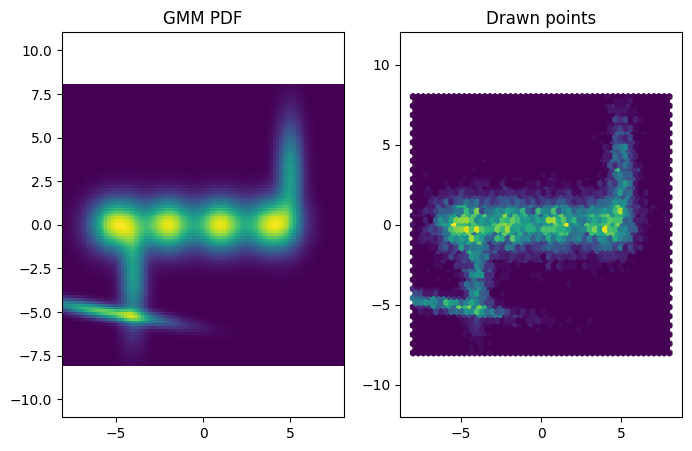

In [55]:
def check_problem3():
    """
    Draw a sample of 10,000 points from the Gaussian Mixture Model (GMM) defined in the lab pdf.
    Plot a heatmap of the probability density function (PDF) of the GMM using plt.pcolormesh,
    and a hexbin plot of the drawn points. Compare the plots to assess the distribution of points.
    """
    # Define the Gaussian Mixture Model (GMM)
    gmm = GMM(n_components=7,
               weights=np.array([0.175, 0.175, 0.175, 0.175, 0.1, 0.1, 0.1]),
               means=np.array([[-5, 0], [-2, 0], [1, 0], [4, 0], [-4, -3], [5, 3], [-5.5, -5]]),
               covars=np.array([[[1, 0], [0, 1]],
                                [[1, 0], [0, 1]],
                                [[1, 0], [0, 1]],
                                [[1, 0], [0, 1]],
                                [[0.25, 0], [0, 4]],
                                [[0.25, 0], [0, 4]],
                                [[6, -1], [-1, 0.25]]]))
        
    points = gmm.draw(10_000)
    
    plt.figure(figsize=(8, 5))
    
    # Probability Density Function (PDF)
    x = np.linspace(-8, 8, 100)
    y = np.linspace(-8, 8, 100)
    X, Y = np.meshgrid(x, y)
    Z = gmm.pdf(np.dstack((X, Y)))

    plt.subplot(1, 2, 1)
    plt.pcolormesh(X, Y, Z)
    plt.axis('equal')
    plt.title("GMM PDF")
    
    # Hexbin Plot
    plt.subplot(1, 2, 2)
    plt.hexbin(points[:, 0], points[:, 1], extent=(-8, 8, -8, 8), gridsize=50)
    plt.axis('equal')
    plt.title("Drawn points")
    
    plt.show()
    
check_problem3()

### Check for problem 4

In [56]:
def check_problem4():
    # Initialize the Gaussian Mixture Model (GMM)
    gmm = init_gmm()

    # Define the data points
    data = np.array([
        [0.5, 1.0],
        [1.0, 0.5],
        [-2.0, 0.7]
    ])
    
    # Define the correct expected results
    correct = np.array([
        [3.49810771e-06, 5.30334386e-05, 9.99997070e-01],
        [9.99996502e-01, 9.99946967e-01, 2.93011749e-06]
    ])
    
    # Compare the computed results with the correct values
    print(f'Are the arrays the same?: {np.allclose(correct, gmm._compute_e_step(data))}')
    
check_problem4()

Are the arrays the same?: True


### Check for problem 5

In [57]:
def check_problem5():
    # Initialize the Gaussian Mixture Model (GMM)
    gmm = init_gmm()

    # Define the data points
    data = np.array([
        [0.5, 1.0],
        [1.0, 0.5],
        [-2.0, 0.7]
    ])
    
    # Define the correct expected results for weights, means, and covariances
    cor_w = np.array([0.3333512, 0.6666488])
    cor_mus = np.array([[-1.99983216, 0.69999044], [0.74998978, 0.75000612]])
    cor_sigs = np.array([[[4.99109197e-04, -2.91933135e-05], 
                          [-2.91933135e-05, 2.43594533e-06]],
                         [[6.25109881e-02, -6.24997069e-02], 
                          [-6.24997069e-02, 6.24999121e-02]]])

    # Compute the new weights, means, and covariances
    new_w, new_mus, new_sigs = gmm._compute_m_step(data)

    # Compare the computed results with the correct values
    print(f'Weights check: {np.allclose(cor_w, new_w)}')
    print(f'Means check: {np.allclose(cor_mus, new_mus)}')
    print(f'Covariance check: {np.allclose(cor_sigs, new_sigs)}')

check_problem5()


Weights check: True
Means check: True
Covariance check: True


### Check for problem 6
Initialize a GMM object in the indicated position and fit the data loaded from the .npy file, then run the cell to see a beloved Disney character

Time to train: 0.26184760010801256


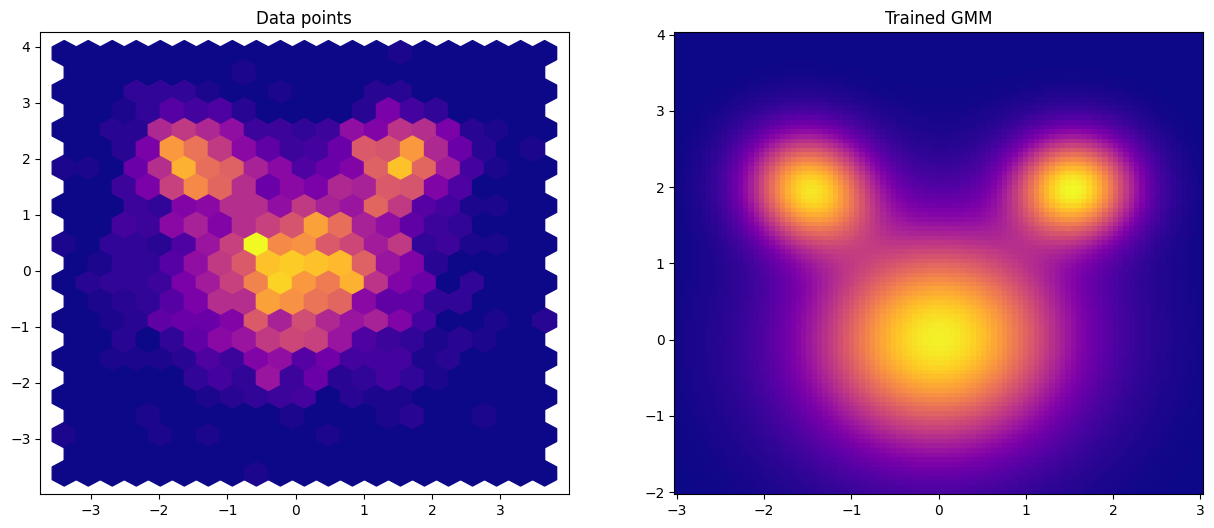

In [58]:
def check_problem6(filename='gmm_data.npy'):
    """
    Train a Gaussian Mixture Model (GMM) on the data provided in the given filename with n_components=3.
    Plot the probability density function (pdf) of the trained GMM and a hexbin plot of the data.
    """
    # Load the data
    data = np.load(filename)
    
    # Start timing the training process
    start = time.perf_counter()
    
    # Initialize and fit the GMM to the data
    gmm = GMM(n_components=3)
    gmm.fit(data)
    
    # End timing
    end = time.perf_counter()

    # Plot the pdf and a hexbin
    plt.figure(figsize=(15,6))
    
    # Define the meshgrid for plotting the pdf
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-2, 4, 100)
    X, Y = np.meshgrid(x, y)
    XY = np.dstack((X, Y))
    
    # Plot the data points
    plt.subplot(1, 2, 1)
    plt.hexbin(data[:, 0], data[:, 1], gridsize=20, cmap='plasma')
    plt.title("Data points")
    
    # Plot the pdf of the trained GMM
    plt.subplot(1, 2, 2)
    plt.pcolormesh(X, Y, gmm.pdf(XY), shading='auto', cmap='plasma')
    plt.title("Trained GMM")
    
    # Print the time taken for training
    print(f"Time to train: {end-start}")
    
    plt.show()

check_problem6()

# Problem 7

Time to fit: 0.5740633010864258


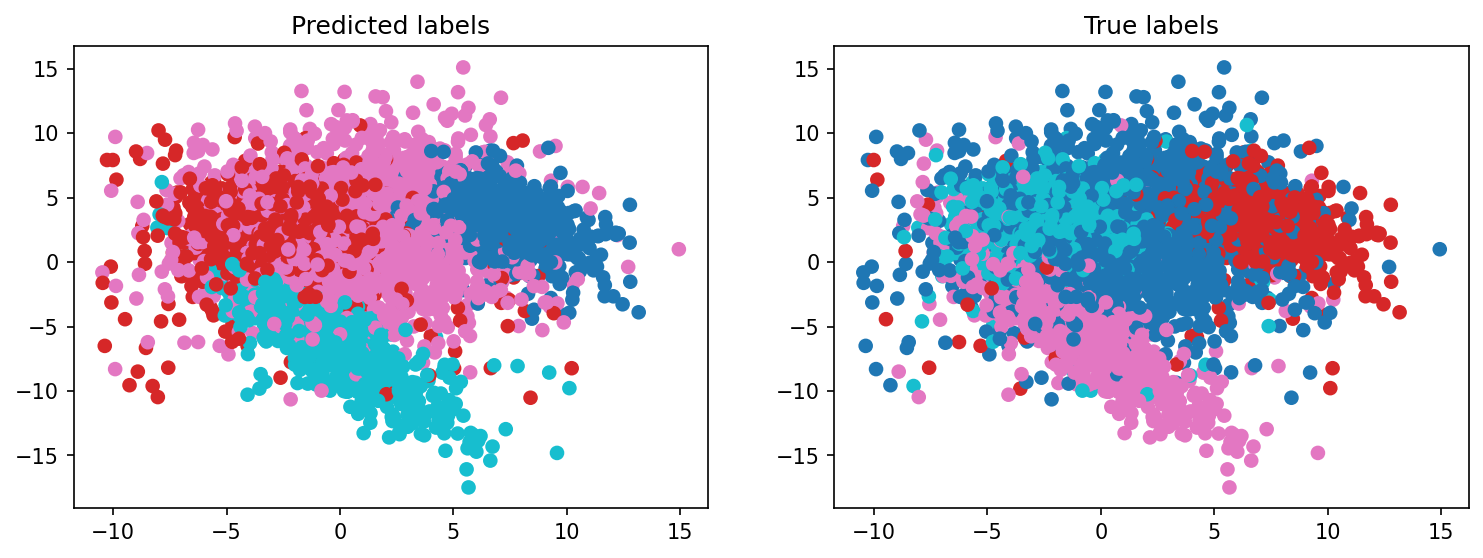

0.8806

In [59]:
def get_accuracy(pred_y, true_y):
    """
    Calculate the clustering accuracy, accounting for possible label permutations.
    
    This function computes the confusion matrix and utilizes scipy's implementation
    of the Hungarian Algorithm (linear_sum_assignment) to find the best label assignment,
    which is generally faster than directly checking permutations.
    """
    # Compute confusion matrix
    cm = confusion_matrix(pred_y, true_y)
    
    # Find the arrangement that maximizes the score
    r_ind, c_ind = linear_sum_assignment(cm, maximize=True)
    
    # Calculate and return the accuracy
    return np.sum(cm[r_ind, c_ind]) / np.sum(cm)
    
def problem7(filename='classification.npz'):
    """
    Cluster the dataset contained in the given filename using a GMM with n_components=4.
    Plot the points with the predicted and actual labels, and compute the model's accuracy.
    Ensure to check for permuted labels.
    
    Args:
        filename (str): The filename containing the dataset.
    
    Returns:
        float: The GMM's accuracy on the dataset.
    """
    # Load the dataset
    data = np.load(filename)
    X, true_y = data['X'], data['y']

    # Initialize the GMM
    gmm = GMM(n_components=4)

    # Fit and predict with the GMM
    start = time.time()
    y_hat = gmm.fit_predict(X)
    print(f"Time to fit: {time.time()-start}")

    # Plot the data
    fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=150)
    ax[0].scatter(X[:,0], X[:,1], c=y_hat, cmap='tab10')
    ax[0].set_title("Predicted labels")

    ax[1].scatter(X[:,0], X[:,1], c=true_y, cmap='tab10')
    ax[1].set_title("True labels")
    plt.show()

    # Calculate and return the accuracy
    return get_accuracy(y_hat, true_y)
    
problem7()

In [60]:
def method_comparison(filename='classification.npz'):
    """
    Again using classification.npz, compare your class, sklearn's GMM implementation, 
    and sklearn's K-means implementation for speed of training and for accuracy of 
    the resulting clusters. Print your results. Be sure to check for permuted labels.
    """
    # Load the data
    data = np.load(filename)
    X, true_y = data['X'], data['y']
    
    # Our class
    start = time.perf_counter()
    gmm = GMM(n_components=4).fit(X)
    end = time.perf_counter()
    gmm_pred = gmm.predict(X)
    gmm_time = end - start
    gmm_acc = get_accuracy(true_y, gmm_pred)
    
    # sklearn GMM
    start = time.perf_counter()
    sk_gmm = GaussianMixture(n_components=4).fit(X)
    end = time.perf_counter()
    sk_gmm_pred = sk_gmm.predict(X)
    sk_gmm_time = end - start
    sk_gmm_acc = get_accuracy(true_y, sk_gmm_pred)
    
    # sklearn K-means
    start = time.perf_counter()
    sk_km = KMeans(n_clusters=4).fit(X)
    end = time.perf_counter()
    sk_km_pred = sk_km.predict(X)
    sk_km_time = end - start
    sk_km_acc = get_accuracy(true_y, sk_km_pred)
    
    print("Our GMM class:")
    print(f"\tAccuracy: {gmm_acc:.4f}")
    print(f"\tTrain time: {gmm_time:.6f} s")
    
    print("sklearn GMM:")
    print(f"\tAccuracy: {sk_gmm_acc:.4f}")
    print(f"\tTrain time: {sk_gmm_time:.6f} s")
    
    print("sklearn K-means:")
    print(f"\tAccuracy: {sk_km_acc:.4f}")
    print(f"\tTrain time: {sk_km_time:.6f} s")
    
method_comparison()

Our GMM class:
	Accuracy: 0.8806
	Train time: 0.435035 s
sklearn GMM:
	Accuracy: 0.8920
	Train time: 0.080652 s
sklearn K-means:
	Accuracy: 0.7544
	Train time: 0.057453 s


c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Problem 8


The following sentence may be accurate but it is not mathematically accurate, make it so:

The main reason K-means was worse than GMM is because its a special case of GMM where the covariance matrix is assumed to be diagonal where the elements are equal. But in our case that must not be true even though we are treating it as such.